In [5]:
import tensorflow as tf
import cartopy.crs as ccrs
from glob import glob
%pylab inline

2021-10-22 13:03:16.017119: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Populating the interactive namespace from numpy and matplotlib


In [6]:
def input_fn(is_training=True):
    def parse_record(record):
        variable_list = ["BCCMASS", "BCFLUXU", "BCFLUXV",
            "BCSMASS", "DMSCMASS", "DMSSMASS", 
            "DUCMASS", "DUCMASS25", "DUFLUXU", "DUFLUXV",
            "DUSMASS", "DUSMASS25", "OCCMASS", "OCFLUXU",
            "OCFLUXV", "OCSMASS", "SO2CMASS", "SO2SMASS",
            "SO4CMASS", "SO4SMASS", "SSCMASS", "SSCMASS25",
            "SSFLUXU", "SSFLUXV", "SSSMASS", "SSSMASS25",
            "SUFLUXU", "SUFLUXV"]
    
        feature = {'lon': tf.io.FixedLenFeature([], tf.string, default_value=""),
                   'lat': tf.io.FixedLenFeature([], tf.string, default_value=""),  
                   'time': tf.io.FixedLenFeature([], tf.float32, default_value=0.),
                   'length': tf.io.FixedLenFeature([], tf.int64, default_value=0),
                   'width': tf.io.FixedLenFeature([], tf.int64, default_value=0)}
        for var in variable_list:
            feature[var] = tf.io.FixedLenFeature([], tf.string, default_value="")
        
        features = tf.io.parse_single_example(record, feature)
        features['lat'] = tf.io.decode_raw(features['lat'], tf.float64)
        features['lon'] = tf.io.decode_raw(features['lon'], tf.float64)
        my_shape = (features['length'], features['width'], 1)
        for var in variable_list:
            features[var] = tf.io.decode_raw(features[var], tf.float32)
            features[var] = tf.reshape(features[var], shape=list(my_shape))

        return features
    
    file_list = sorted(glob(tfrecords_path))
    dataset = tf.data.TFRecordDataset(file_list)

    if is_training:
        if shuffle:
            dataset = dataset.shuffle(buffer_size=32)
        else:
            dataset = dataset.repeat()

    dataset = dataset.map(parse_record)
    dataset = dataset.batch(16)
    dataset = tf.data.Dataset.zip((dataset, dataset))

    return dataset

In [7]:
tfrecords_path = '/lcrc/group/earthscience/rjackson/MERRA2/tfrecords/*.tfrecord'
ds = input_fn()

2021-10-22 13:03:40.533923: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-22 13:03:40.535587: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-22 13:03:40.634485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-10-22 13:03:40.634523: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-22 13:03:40.960067: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-22 13:03:40.960104: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

In [42]:
for x in ds.take(3):
    print(x[0]['BCCMASS'].shape)

(16, 20, 32, 1)
(16, 20, 32, 1)
(16, 20, 32, 1)


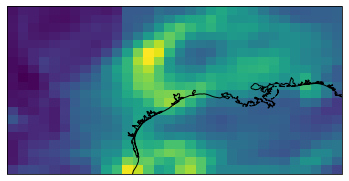

In [61]:
inp_data = [x for x in ds.take(1)][0]
x, y = np.meshgrid(inp_data[0]['lon'][0], inp_data[0]['lat'][0])
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.pcolormesh(x, y, inp_data[0]['BCCMASS'][1, :, :, 0])
ax.coastlines()

In [59]:
inp_data[0]['lon']

<tf.Tensor: shape=(16, 33), dtype=float64, numpy=
array([[-105.   , -104.375, -103.75 , -103.125, -102.5  , -101.875,
        -101.25 , -100.625, -100.   ,  -99.375,  -98.75 ,  -98.125,
         -97.5  ,  -96.875,  -96.25 ,  -95.625,  -95.   ,  -94.375,
         -93.75 ,  -93.125,  -92.5  ,  -91.875,  -91.25 ,  -90.625,
         -90.   ,  -89.375,  -88.75 ,  -88.125,  -87.5  ,  -86.875,
         -86.25 ,  -85.625,  -85.   ],
       [-105.   , -104.375, -103.75 , -103.125, -102.5  , -101.875,
        -101.25 , -100.625, -100.   ,  -99.375,  -98.75 ,  -98.125,
         -97.5  ,  -96.875,  -96.25 ,  -95.625,  -95.   ,  -94.375,
         -93.75 ,  -93.125,  -92.5  ,  -91.875,  -91.25 ,  -90.625,
         -90.   ,  -89.375,  -88.75 ,  -88.125,  -87.5  ,  -86.875,
         -86.25 ,  -85.625,  -85.   ],
       [-105.   , -104.375, -103.75 , -103.125, -102.5  , -101.875,
        -101.25 , -100.625, -100.   ,  -99.375,  -98.75 ,  -98.125,
         -97.5  ,  -96.875,  -96.25 ,  -95.625,  -95.   

In [11]:
y = [x for x in ds.take(1)]
y[0][0]['width'][0].numpy()

<tf.Tensor: shape=(), dtype=int64, numpy=32>